<a href="https://colab.research.google.com/github/WoojinJeonkr/Academy-Learning/blob/main/Distilling_Vision_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 증류식 비전 트랜스포머
- 내용 출처: [Distilling Vision Transformers](https://keras.io/examples/vision/deit/)
- 목표: Data-efficient image Transformers(DeiT) 논문( Touvron et al.)에 나와있는
transformer 기반의 vision models 재현

## 01. 설치

In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 2.9 MB/s 


## 02. 라이브러리 불러오기

In [2]:
from typing import List

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers

tfds.disable_progress_bar()
tf.keras.utils.set_random_seed(42)

## 03. 파라미터 설정

In [3]:
# Model
MODEL_TYPE = "deit_distilled_tiny_patch16_224"
RESOLUTION = 224
PATCH_SIZE = 16
NUM_PATCHES = (RESOLUTION // PATCH_SIZE) ** 2
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 192
NUM_HEADS = 3
NUM_LAYERS = 12
MLP_UNITS = [
    PROJECTION_DIM * 4,
    PROJECTION_DIM,
]
DROPOUT_RATE = 0.0
DROP_PATH_RATE = 0.1

# Training
NUM_EPOCHS = 20
BASE_LR = 0.0005
WEIGHT_DECAY = 0.0001

# Data
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
NUM_CLASSES = 5

## 04. tf_flowers 데이터세트 불러오기 및 데이터 전처리

In [5]:
# 전처리 함수 정의
def preprocess_dataset(is_training=True):
    def fn(image, label):
        if is_training:
            image = tf.image.resize(image, (RESOLUTION + 20, RESOLUTION + 20))
            image = tf.image.random_crop(image, (RESOLUTION, RESOLUTION, 3))
            image = tf.image.random_flip_left_right(image)
        else:
            image = tf.image.resize(image, (RESOLUTION, RESOLUTION))
        label = tf.one_hot(label, depth=NUM_CLASSES)
        return image, label
    return fn
    
def prepare_dataset(dataset, is_training=True):
    if is_training:
        dataset = dataset.shuffle(BATCH_SIZE * 10)
    dataset = dataset.map(preprocess_dataset(is_training), num_parallel_calls=AUTO)
    return dataset.batch(BATCH_SIZE).prefetch(AUTO)

In [6]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers", split=["train[:90%]", "train[90%:]"], as_supervised=True
)

Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [7]:
num_train = train_dataset.cardinality()
num_val = val_dataset.cardinality()
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

Number of training examples: 3303
Number of validation examples: 367


In [8]:
train_dataset = prepare_dataset(train_dataset, is_training=True)
val_dataset = prepare_dataset(val_dataset, is_training=False)

## 05. ViT의 DeiT 변형 구현
- DeiT는 ViT의 확장이므로 먼저 ViT를 구현한 다음 DeiT의 구성 요소를 지원하도록 확장한다

In [9]:
# 정규화를 위해 DeiT에서 사용되는 확률적 깊이에 대한 레이어 구현
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super().__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=True):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

In [11]:
# MLP 및 Transformer 블록 구현

# FFN for a Transformer block
def mlp(x, dropout_rate: float, hidden_units: List):
    for (idx, units) in enumerate(hidden_units):
        x = layers.Dense(
            units,
            activation=tf.nn.gelu if idx == 0 else None,
        )(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Transformer block with pre-norm
def transformer(drop_prob: float, name: str) -> keras.Model:
    num_patches = NUM_PATCHES + 2 if "distilled" in MODEL_TYPE else NUM_PATCHES + 1
    encoded_patches = layers.Input((num_patches, PROJECTION_DIM))

    x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(encoded_patches)

    attention_output = layers.MultiHeadAttention(
        num_heads=NUM_HEADS,
        key_dim=PROJECTION_DIM,
        dropout=DROPOUT_RATE,
    )(x1, x1)
    attention_output = (
        StochasticDepth(drop_prob)(attention_output) if drop_prob else attention_output
    )

    x2 = layers.Add()([attention_output, encoded_patches])
    x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

    x4 = mlp(x3, hidden_units=MLP_UNITS, dropout_rate=DROPOUT_RATE)
    x4 = StochasticDepth(drop_prob)(x4) if drop_prob else x4

    outputs = layers.Add()([x2, x4])

    return keras.Model(encoded_patches, outputs, name=name)

In [12]:
# ViT 논문에서 사용된 풀링 전략에 따라 구성 요소 위에 클래스 구현
class ViTClassifier(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.projection = keras.Sequential(
            [
                layers.Conv2D(
                    filters=PROJECTION_DIM,
                    kernel_size=(PATCH_SIZE, PATCH_SIZE),
                    strides=(PATCH_SIZE, PATCH_SIZE),
                    padding="VALID",
                    name="conv_projection",
                ),
                layers.Reshape(
                    target_shape=(NUM_PATCHES, PROJECTION_DIM),
                    name="flatten_projection",
                ),
            ],
            name="projection",
        )

        init_shape = (
            1,
            NUM_PATCHES + 1,
            PROJECTION_DIM,
        )
        self.positional_embedding = tf.Variable(
            tf.zeros(init_shape), name="pos_embedding"
        )

        dpr = [x for x in tf.linspace(0.0, DROP_PATH_RATE, NUM_LAYERS)]
        self.transformer_blocks = [
            transformer(drop_prob=dpr[i], name=f"transformer_block_{i}")
            for i in range(NUM_LAYERS)
        ]

        initial_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.cls_token = tf.Variable(
            initial_value=initial_value, trainable=True, name="cls"
        )

        self.dropout = layers.Dropout(DROPOUT_RATE)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)
        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        projected_patches = self.projection(inputs)

        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        projected_patches = tf.concat([cls_token, projected_patches], axis=1)

        encoded_patches = (
            self.positional_embedding + projected_patches
        )
        encoded_patches = self.dropout(encoded_patches)

        for transformer_module in self.transformer_blocks:
            encoded_patches = transformer_module(encoded_patches)

        representation = self.layer_norm(encoded_patches)

        encoded_patches = representation[:, 0]

        output = self.head(encoded_patches)
        return output

In [13]:
# 증류하는 동안 클래스 토큰에 해당하는 로짓을 실제 레이블과 비교하고 증류 토큰에 해당하는 로짓을 교사의 예측과 비교
class ViTDistilled(ViTClassifier):
    def __init__(self, regular_training=False, **kwargs):
        super().__init__(**kwargs)
        self.num_tokens = 2
        self.regular_training = regular_training

        init_value = tf.zeros((1, 1, PROJECTION_DIM))
        self.dist_token = tf.Variable(init_value, name="dist_token")
        self.positional_embedding = tf.Variable(
            tf.zeros(
                (
                    1,
                    NUM_PATCHES + self.num_tokens,
                    PROJECTION_DIM,
                )
            ),
            name="pos_embedding",
        )

        self.head = layers.Dense(
            NUM_CLASSES,
            name="classification_head",
        )
        self.head_dist = layers.Dense(
            NUM_CLASSES,
            name="distillation_head",
        )

    def call(self, inputs, training=True):
        n = tf.shape(inputs)[0]

        projected_patches = self.projection(inputs)

        cls_token = tf.tile(self.cls_token, (n, 1, 1))
        dist_token = tf.tile(self.dist_token, (n, 1, 1))
        cls_token = tf.cast(cls_token, projected_patches.dtype)
        dist_token = tf.cast(dist_token, projected_patches.dtype)
        projected_patches = tf.concat(
            [cls_token, dist_token, projected_patches], axis=1
        )

        encoded_patches = (
            self.positional_embedding + projected_patches
        )
        encoded_patches = self.dropout(encoded_patches)

        for transformer_module in self.transformer_blocks:
            encoded_patches = transformer_module(encoded_patches)

        representation = self.layer_norm(encoded_patches)

        x, x_dist = (
            self.head(representation[:, 0]),
            self.head_dist(representation[:, 1]),
        )

        if not training or self.regular_training:
            return (x + x_dist) / 2

        elif training:
            return x, x_dist

In [14]:
# ViTDistilled클래스를 초기화하고 예상대로 호출할 수 있는지 확인
deit_tiny_distilled = ViTDistilled()

dummy_inputs = tf.ones((2, 224, 224, 3))
outputs = deit_tiny_distilled(dummy_inputs, training=False)
print(outputs.shape)

(2, 5)


## 06. 트레이너 구현

### DeiT 작성자가 사용한 손실 함수
1) CE: 교차 엔트로피   
2) psi: 소프트맥스 함수   
3) Z_s: 학생 예측   
4) y: 실제 레이블   
5) y_t: 교사 예측   

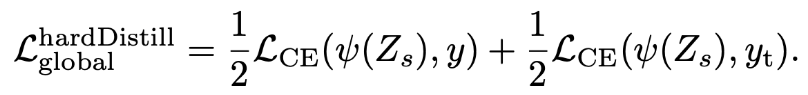

In [16]:
from IPython.display import Image
Image('/content/008.png')

In [17]:
class DeiT(keras.Model):
    def __init__(self, student, teacher, **kwargs):
        super().__init__(**kwargs)
        self.student = student
        self.teacher = teacher

        self.student_loss_tracker = keras.metrics.Mean(name="student_loss")
        self.dist_loss_tracker = keras.metrics.Mean(name="distillation_loss")

    @property
    def metrics(self):
        metrics = super().metrics
        metrics.append(self.student_loss_tracker)
        metrics.append(self.dist_loss_tracker)
        return metrics

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
    ):
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn

    def train_step(self, data):
        x, y = data

        teacher_predictions = tf.nn.softmax(self.teacher(x, training=False), -1)
        teacher_predictions = tf.argmax(teacher_predictions, -1)

        with tf.GradientTape() as tape:
            cls_predictions, dist_predictions = self.student(x / 255.0, training=True)

            student_loss = self.student_loss_fn(y, cls_predictions)
            distillation_loss = self.distillation_loss_fn(
                teacher_predictions, dist_predictions
            )
            loss = (student_loss + distillation_loss) / 2

        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        student_predictions = (cls_predictions + dist_predictions) / 2
        self.compiled_metrics.update_state(y, student_predictions)
        self.dist_loss_tracker.update_state(distillation_loss)
        self.student_loss_tracker.update_state(student_loss)

        results = {m.name: m.result() for m in self.metrics}
        return results

    def test_step(self, data):
        x, y = data

        y_prediction = self.student(x / 255.0, training=False)

        student_loss = self.student_loss_fn(y, y_prediction)

        self.compiled_metrics.update_state(y, y_prediction)
        self.student_loss_tracker.update_state(student_loss)

        results = {m.name: m.result() for m in self.metrics}
        return results

    def call(self, inputs):
        return self.student(inputs / 255.0, training=False)

## 07. 교사 모델 불러오기
-  데이터 세트에서 미세 조정된 ResNets(Kolesnikov et al.tf_flowers )의 BiT 제품군을 기반으로 약 2억 1200만 개의 매개변수 내장

In [18]:
!wget -q https://github.com/sayakpaul/deit-tf/releases/download/v0.1.0/bit_teacher_flowers.zip
!unzip -q bit_teacher_flowers.zip

In [19]:
bit_teacher_flowers = keras.models.load_model("bit_teacher_flowers")

## 08. 증류를 통한 훈련

In [ ]:
deit_tiny = ViTDistilled()
deit_distiller = DeiT(student=deit_tiny, teacher=bit_teacher_flowers)

lr_scaled = (BASE_LR / 512) * BATCH_SIZE
deit_distiller.compile(
    optimizer=tfa.optimizers.AdamW(weight_decay=WEIGHT_DECAY, learning_rate=lr_scaled),
    metrics=["accuracy"],
    student_loss_fn=keras.losses.CategoricalCrossentropy(
        from_logits=True, label_smoothing=0.1
    ),
    distillation_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
_ = deit_distiller.fit(train_dataset, validation_data=val_dataset, epochs=NUM_EPOCHS)

Epoch 1/20
